<a href="https://colab.research.google.com/github/antonsysoev/DeepLearning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация подписи к изображению

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

Для обучения модели будем использовать [набор данных COCO (common objects in context),](https://cocodataset.org/#home) он размечени для решения довольно большого числа задач: локализация, сегментация, генерация подписей. Для каждого изобржения предусмотрено пять разных вариантов подписей. Код ниже скачает картинки и подписи к ним.

![](https://cocodataset.org/images/captions-splash.jpg)

> __Внимание:__ мы будем использовать данные размером 13 ГБ. Они будут скачиваться довольно долго и займут какое-то место. Это одна из причин работать в колабе.

In [2]:
# Скачиваем файлы с аннотациями картинок
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip)

# Скачиваем картинки
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

13510573713/13510573713 [==============================] - 408s 0us/step


In [3]:
annotation_file

'/content/annotations/captions_train2014.json'

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
annotations['annotations'][0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

In [6]:
# Сгруппируем все подписи по соотвествующим картинкам
from collections import defaultdict
image_path_to_caption = defaultdict(list)

for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

Возьмём для тестов первые $6000$ картинок. При желании можно запустить код на всех данных и получить более хороший результат.

In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths) # перемешали пути к картинкам

# Взяли 6к картинок, для каждой есть 5 подписей => у нас 30к примеров
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A black cat hunches on the ground, holding a bird. <end>


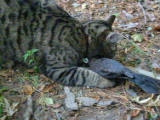

In [9]:
print(train_captions[42])
Image.open(img_name_vector[42])

# Превращаем картинки в эмбединги

Нам нужно будет дальше прогонать картинки через какую-нибудь нейросеть и получить их эмбединги. Возьмём предобученную Incemtion v3. Напишем функцию, которая готовит картинку для нашей нейросети.

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # десериализовали картинку в числа
    img = tf.image.resize(img, (299, 299))       # изменили размерность изображения
    img = tf.keras.applications.inception_v3.preprocess_input(img)  # отнормировали на отрезок [-1, 1]
    return img, image_path

__Задание 1:__  подгрузите InceptionV3 с весами предобученными на IMAGENET. Инициализируйте модель. На выход из неё потребуйте вектора с последнего слоя.

In [25]:
# Ваш код
from tensorflow.keras.applications.inception_v3 import InceptionV3

feature_extractor = InceptionV3(include_top=False)

input_values = feature_extractor.input
output_values = feature_extractor.layers[-1].output

image_features_extract_model = tf.keras.Model(input_values,output_values)

87910968/87910968 [==============================] - 2s 0us/step


Прогоним наши картинки через нейросеть и получим для каждой эмбединг.

In [26]:
from tqdm.notebook import tqdm

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
).batch(32)

In [27]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/188 [00:00<?, ?it/s]

# Предобработка подписей

Сначала вы токенизируете подписи (например, разделив их на пробелы). Это дает нам словарь всех уникальных слов в данных (например, «серфинг», «футбол» и т. Д.).

Затем вы ограничите размер словарного запаса до 5000 верхних слов (для экономии памяти). Вы замените все остальные слова токеном «UNK» (неизвестно).
Затем вы создаете сопоставления «слово-индекс» и «индекс-слово».
Наконец, вы дополняете все последовательности, чтобы они были той же длины, что и самая длинная.

In [28]:
get_max_length = lambda tensor: max(len(t) for t in tensor)

In [29]:
# Предобработчик умеет брать top_k слов из словаря,
# отбрасывать пунктуацию и заменять неизвестные слова на <unk>

top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [30]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [31]:
# А ещё он умеет делать OHE!
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [32]:
# Для каждго вектора делаем padding до максимальной длины подписи
max_length = get_max_length(train_seqs)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

Разделим выборку на тренировочную и тестовую.

In [33]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [34]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24016, 24016, 6004, 6004)

Заведём итератор для обучения.

In [35]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Размер вектора на выходе из InceptionV3 это (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [36]:
# Подгружаем заранее сохранённые эмбединги
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Соберём модель

Энкодер, который генерирует для картинок эмбединги, у нас уже есть. Теперь нам нужен декодер. Его мы возьмём из статьи [Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf)

__Задание 2:__ заполните пропущенные строки.

In [49]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        # Ищем скрытый слой для attention
        attention_hidden_layer = tf.nn.tanh(self.W1(features)+self.W2(hidden))

        # score shape == (batch_size, 64, 1)
        # Находим внимание для каждой фичи из входной картинки
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        # Находим веса для внимения
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # Находим векто контекста
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Мы уже превратили наши картинки в эмбединги. Давайте немного уменьщим размерность этого эмбединга с помощью полносвязного слоя.

In [50]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

Наконец, соберём рекурентную сетку с механизмом внимания для генерации подписей.

In [51]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)


    def call(self, x, features, hidden):
        # Применяем attention к картинке и скрытому слою из RNN
        # features - выход из CNN_encoder
        context_vector, attention_weights = self.attention(features, hidden)

        # Наблюдаем за текстом, на вход идёт эмбед размера (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # Размерность после конката (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Отправляем объединенный вектор в рекурентную ячейку
        output, state = self.gru(x)

        # x shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

- На вход в модель подаётся эмбединг картинки
- Выход энкодера - представление картинки, которое подаётся на вход декодеру
- Декодер возвращает предсказание и своё скрытое состояние
- Скрытое состояние передаётся обратно в модель, а предсказания используются для расчёта потерь
- Целевое слово передаётся в качестве следующего входа в декодер вместе со скрытым состоянием, модель прогнозирует следующее слово.

# Пишем цикл для обучения

In [53]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

Обучение довольно тяжеловесное, поэтому давайте зададим процедуру для сохранения чекпойнтов.

In [54]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Восстановление последнего сохранённого чекпойнта
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [56]:
loss_plot = []

In [57]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # подписи разных картинок независимы,
    # скрытое состояние надо инициализировать для каждого  батча заново
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Применяем декодер к входной картинке, слову dec_input и скрытому состоянию
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # копим ошибку на последовательности
            loss += loss_function(target[:, i], predictions)

            # на вход подаём реальное слово (teacher forcing)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [59]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.8565
Epoch 1 Batch 100 Loss 0.7203
Epoch 1 Batch 200 Loss 0.7615
Epoch 1 Batch 300 Loss 0.7215


ValueError: in user code:

    File "<ipython-input-57-017ba9cc825f>", line 16, in train_step  *
        predictions, hidden, _ = decoder(dec_input, features, hidden)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileysdpbivc.py", line 10, in tf__call
        (context_vector, attention_weights) = ag__.converted_call(ag__.ld(self).attention, (ag__.ld(features), ag__.ld(hidden)), None, fscope)
    File "/tmp/__autograph_generated_file8y9bpcao.py", line 11, in tf__call
        attention_hidden_layer = ag__.converted_call(ag__.ld(tf).nn.tanh, (ag__.converted_call(ag__.ld(self).W1, (ag__.ld(features),), None, fscope) + ag__.converted_call(ag__.ld(self).W2, (ag__.ld(hidden),), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'rnn__decoder_1' (type RNN_Decoder).
    
    in user code:
    
        File "<ipython-input-51-a55a9eb58e2e>", line 20, in call  *
            context_vector, attention_weights = self.attention(features, hidden)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file8y9bpcao.py", line 11, in tf__call
            attention_hidden_layer = ag__.converted_call(ag__.ld(tf).nn.tanh, (ag__.converted_call(ag__.ld(self).W1, (ag__.ld(features),), None, fscope) + ag__.converted_call(ag__.ld(self).W2, (ag__.ld(hidden),), None, fscope),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'bahdanau_attention_1' (type BahdanauAttention).
        
        in user code:
        
            File "<ipython-input-49-7e62d63a9c8b>", line 16, in call  *
                attention_hidden_layer = tf.nn.tanh(self.W1(features)+self.W2(hidden))
        
            ValueError: Dimensions must be equal, but are 64 and 16 for '{{node rnn__decoder_1/bahdanau_attention_1/add}} = AddV2[T=DT_FLOAT](rnn__decoder_1/bahdanau_attention_1/dense_9/BiasAdd, rnn__decoder_1/bahdanau_attention_1/dense_10/BiasAdd)' with input shapes: [16,64,512], [16,512].
        
        
        Call arguments received by layer 'bahdanau_attention_1' (type BahdanauAttention):
          • features=tf.Tensor(shape=(16, 64, 256), dtype=float32)
          • hidden=tf.Tensor(shape=(16, 512), dtype=float32)
    
    
    Call arguments received by layer 'rnn__decoder_1' (type RNN_Decoder):
      • x=tf.Tensor(shape=(16, 1), dtype=int32)
      • features=tf.Tensor(shape=(16, 64, 256), dtype=float32)
      • hidden=tf.Tensor(shape=(16, 512), dtype=float32)


In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Применение модели

Применение модели работает точно также, как и цикл для обучения. Разница в том, чтот тут не используется teacher forcing. На каждом шаге на вход декодеру подаются предыдущие прогнозы. Когда модель предсказывает токен `<end>`, генерация подписи преркащается.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# Генерируем подпись на валидационных данных
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Попробуем то же самое, но уже на своих изображениях!

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)